# Notebook para ir probando código

### Prueba de calculadora de energía de una secuencia de aminoácidos

In [1]:
"""
countH(HPlist)

Given a vector (H,H,P,H,P,...)=(-1,-1,1,-1,1,...), counts the number of H-H bonds within the array.
"""
function countH(HPlist)
    s=0
    for i in 1:(length(HPlist)-1)
        if HPlist[i] == 1
            continue
        elseif HPlist[i] == -1
            if HPlist[i+1] == 1
                continue
            elseif HPlist[i+1] == -1
                s=s+1
            end
        end
    end
    return s
end

# It works as expected

countH([-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1])

7

In [5]:
"""
energy(N,edo,HPlist)

Given a an array side N, a matrix encoding the aminoacids positions, and an array containing the sequence of H,P aminoacids; the function
outputs the energy of the configuration.
"""
function energy(N,edo,HPlist)
    red=makeLattice(N,edo,HPlist)
    
    # I create an auxiliary array with periodic boundary conditions.
    redaux=zeros(Int8,(N+2,N+2))
    redaux[2:end-1,2:end-1]=red
    redaux[end,2:end-1]=red[1,:]
    redaux[1,2:end-1]=red[end,:]
    redaux[2:end-1,end]=red[:,1]
    redaux[2:end-1,1]=red[:,end]
    
    # Next, I iterate over the protein´s vertices and compute the number of H-H bonds.
    # To avoid counting the covalent bonds, I substract two times the value of `countBH(HPlist)`.
    enp=0
    for i in 1:length(HPlist)
        if HPlist[i]==1 
            continue
        elseif HPlist[i]==-1
            x=edo[i,1]+1
            y=edo[i,2]+1 # I have to shift both indices by one place because we are working on the extended array `redaux`.
            cruz=[redaux[x+1,y],redaux[x,y+1],redaux[x-1,y],redaux[x,y-1]] # I define an array with the next closest neighbors.
            c=count(i->(i==-1),cruz)
            enp=enp+(c)
        end
    end
    en=((enp)-2*countH(HPlist))/2 # The total energy is obtained by substracting the number of covalent bonds to `enp` 
    #and dividing the resulting number by two.
    return -en
end

# Function works properly


energy(10,[[4 4];[5 4];[5 5];[4 5];[3 5];[3 6];[2 6];[2 5];[2 4];[3 4];[3 3]],[-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1])

-4.0

### Prueba de indices periódicos

In [3]:
# Now, I want a function which takes an array and two indices, and returns the indices taking periodic b.c. into account

"""
    periodicInd2D(A,indices)

Given a 2D array `A` and a couple of indices, returns the indices for the equivalent array with periodic boundary conditions.
"""
function periodicInd2D(A,indices)
    lx,ly=size(A)
    ix,iy=indices
    Ix=mod1(ix,lx)
    Iy=mod1(iy,ly)
        
    return [Ix,Iy]
end

"""
    periodicArr2D(A,indices)

Given a 2D array `A` and a couple of indices, returns the value of the equivalent array with periodic boundary conditions.
"""
function periodicArr2D(A,indices)
    lx,ly=size(A)
    ix,iy=indices
    Ix=mod1(ix,lx)
    Iy=mod1(iy,ly)
        
    return A[Ix,Iy]
end

periodicArr2D

### Prueba de función que comprueba la validez de una configuración.

In [9]:
# Since I end up setting uo the array wchich contains the protein sequence multiple times, I write a function to do 
#just that.
"""
    makeLattice(N,edo,HPlist)

Given a value for the lattice size `N`, a matrix encoding the aminoacids positions `edo`, and an array containing 
the sequence of H,P aminoacids `HPlist`; creates a 2D array containing the amino acid sequence.
"""
function makeLattice(N,edo,HPlist)
    red=zeros(Int8,(N,N))
    for k in 1:length(HPlist)
        x=edo[k,1]
        y=edo[k,2]
        x,y=periodicInd2D(red,[x,y])
        red[x,y]=HPlist[k]
    end
    return red
end




@enum directions::Int8 begin
        forwards=1
        backwards=2
    end
# Now, the task is to write a function which determines whether a given protein sequence is valid. This function works 
# only for the middle indices.
"""
    validConf(N,ind,edo,HPlist,dir)

Given a 2D array of side `N`, a matrix encoding the aminoacids positions `edo`, an index `ind` , an array containing 
the sequence of H,P aminoacids `HPlist`, and a direction `dir`; determines whether the protein structure is valid or not.
"""
function validConf(N,ind,edo,HPlist,dir)
    
    # I set up the protein within the array.
    red=makeLattice(N,edo,HPlist)
    display(red)

    # Next, I iterate over the protein´s vertices, computing the "distance" to the next vertex. The direction in which I check the
    # structure is determined by `dir`.
    ans=true

    if dir == backwards
        if ind !=1
            for j in ind:-1:2
                x1,y1=edo[j,:]
                x1,y1=periodicInd2D(red,[x1,y1]) # Make the indices periodic.
                x2,y2=edo[j-1,:]
                x2,y2=periodicInd2D(red,[x2,y2]) # Make the indices periodic.
                dx=abs(x1-x2)
                dy=abs(y1-y2)
    
                # Before assesing the validity of the sequence, we need to consider the case where the two elements being compared
                # are located at the ends of the array `red`. In such case, the distance between them doesn´t necessarily exceed the
                # limit.
    
                xcond1= x1 == 1 && x2 == N
                xcond2= x1 == N && x2 == 1
                xcond= xcond1 || xcond2 
                
                ycond1= y1 == 1 && y2 == N
                ycond2= y1 == N && y2 == 1
                ycond= ycond1 || ycond2
    
                if dx > 1
                    if xcond == false
                        ans=false
                        break
                    end
                end
                if dy > 1
                    if ycond == false
                        ans=false
                        break
                    end
                end
            end
        end



    elseif dir == forwards
        if ind != length(HPlist)
            for j in ind:length(HPlist)-1
                x1,y1=edo[j,:]
                x1,y1=periodicInd2D(red,[x1,y1]) # Make the indices periodic.
                x2,y2=edo[j+1,:]
                x2,y2=periodicInd2D(red,[x2,y2]) # Make the indices periodic.
                dx=abs(x1-x2)
                dy=abs(y1-y2)
    
                # Before assesing the validity of the sequence, we need to consider the case where the two elements being compared
                # are located at the ends of the array `red`. In such case, the distance between them doesn´t necessarily exceed the
                # limit.
    
                xcond1= x1 == 1 && x2 == N
                xcond2= x1 == N && x2 == 1
                xcond= xcond1 || xcond2 
                
                ycond1= y1 == 1 && y2 == N
                ycond2= y1 == N && y2 == 1
                ycond= ycond1 || ycond2
    
                if dx > 1
                    if xcond == false
                        ans=false
                        break
                    end
                end
                if dy > 1
                    if ycond == false
                        ans=false
                        break
                    end
                end
            end
        end
    end

    return ans
end


validConf(10,8,[[6 3];[5 4];[5 5];[4 5];[3 5];[3 6];[2 6];[2 5];[2 4];[3 4];[3 3]],[-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1],backwards)

10×10 Matrix{Int8}:
 0  0   0   0   0   0  0  0  0  0
 0  0   0  -1  -1  -1  0  0  0  0
 0  0  -1  -1  -1  -1  0  0  0  0
 0  0   0   0  -1   0  0  0  0  0
 0  0   0   1   1   0  0  0  0  0
 0  0  -1   0   0   0  0  0  0  0
 0  0   0   0   0   0  0  0  0  0
 0  0   0   0   0   0  0  0  0  0
 0  0   0   0   0   0  0  0  0  0
 0  0   0   0   0   0  0  0  0  0

true

### Prueba de función que mueve un solo punto dentro de un array.

In [17]:
eddo=[[4 4];[5 4];[5 5];[4 5];[3 5];[3 6];[2 6];[2 5];[2 4];[3 4];[3 3]]
HPplist=[-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1]
redd=zeros(Int8,(10,10))

for k in 1:length(HPplist)
    x=eddo[k,1]
    y=eddo[k,2]
    redd[x,y]=HPplist[k]
end

display(redd)

"""
    singleMove2D(arr,pos1,pos2)

Given a 2D array `arr`, an initial position  `pos1` ([xᵢ,yᵢ]) and a final desired position `pos2` ([xₛ,yₛ]); moves the value of 
`arr[xᵢ,yᵢ]` to  `arr[xₛ,yₛ]`.
"""
function singleMove2D(arr,pos1,pos2)
    red=copy(arr)
    xi,yi=pos1
    xi,yi=periodicInd2D(red,[xi,yi])
    xf,yf=pos2
    xf,yf=periodicInd2D(red,[xf,yf])
    if pos1 != pos2
        red[xf,yf]=arr[xi,yi]
        red[xi,yi]=0
    end
    return red
end

# La función funciona bien

display(singleMove2D(redd,[5,5],[6,6]))

10×10 Matrix{Int8}:
 0  0   0   0   0   0  0  0  0  0
 0  0   0  -1  -1  -1  0  0  0  0
 0  0  -1  -1  -1  -1  0  0  0  0
 0  0   0  -1  -1   0  0  0  0  0
 0  0   0   1   1   0  0  0  0  0
 0  0   0   0   0   0  0  0  0  0
 0  0   0   0   0   0  0  0  0  0
 0  0   0   0   0   0  0  0  0  0
 0  0   0   0   0   0  0  0  0  0
 0  0   0   0   0   0  0  0  0  0

10×10 Matrix{Int8}:
 0  0   0   0   0   0  0  0  0  0
 0  0   0  -1  -1  -1  0  0  0  0
 0  0  -1  -1  -1  -1  0  0  0  0
 0  0   0  -1  -1   0  0  0  0  0
 0  0   0   1   0   0  0  0  0  0
 0  0   0   0   0   1  0  0  0  0
 0  0   0   0   0   0  0  0  0  0
 0  0   0   0   0   0  0  0  0  0
 0  0   0   0   0   0  0  0  0  0
 0  0   0   0   0   0  0  0  0  0

### Prueba de código para contar pull moves

In [16]:
"""
    makecross2D(red,inds)

Given a 2D array `red`, and a couple of indices `inds`; returns the values of the nearest neighbors to the given position,
in clockwise order. 
"""
function makecross2D(red,inds)
    A=red
    x,y=inds
    x,y=periodicInd2D(red,[x,y])

    cross=Int8[periodicArr2D(A,[x-1,y]),periodicArr2D(A,[x,y+1]),periodicArr2D(A,[x+1,y]),periodicArr2D(A,[x,y-1])]
    return cross
end

"""
    distance2D(red,inds1,inds2)

 Given an array `red`, two pairs of indices `inds1,inds2`; return the distance between the given positions.
"""
function distance2D(red,inds1,inds2)
    x1,y1=inds1
    x2,y2=inds2
    x1,y1=periodicInd2D(red,inds1)
    x2,y2=periodicInd2D(red,inds2)

    N=size(red)[1]

    xcond1= x1 == 1 && x2 == N
    xcond2= x1 == N && x2 == 1
    xcond= xcond1 || xcond2 
            
    ycond1= y1 == 1 && y2 == N
    ycond2= y1 == N && y2 == 1
    ycond= ycond1 || ycond2

    if xcond
        dx=1
    else
        dx=abs(x1-x2)
    end

    if ycond
        dy=1
    else
        dy=abs(y1-y2)
    end

    d=dx+dy
    return (d,dx,dy)
end

distance2D

In [6]:
"""
    validConfEnd2D(red,ind,inds,edo,HPlist)

Given a 2D array `red`, a position `ind`, a couple of indices `inds`, a matrix encoding the aminoacids positions `edo`,
and an array containing the sequence of H,P aminoacids `HPlist`; checks whether the position `inds` for the selected amino acid
is valid. The necessary condition is for the end amino acid not to be adjacent to the chain.
"""
function validConfEnd2D(red,ind,inds,edo,HPlist)
    x,y=inds
    x,y=periodicInd2D(red,[x,y])

    # `ind` can only be `1` or `length(HPlist)`, meaning this function only checks for the validity of a configuration 
    # at the ends of the chain.

    value = true
    if ind == 1
        for k in 3:length(HPlist) # Iterate over the elements of the chain not directly linked to `ind`.
            xk,yk=edo[k,:]
            xk,yk=periodicInd2D(red,[xk,yk])
            dist=distance2D(red,[x,y],[xk,yk])[1]
            if dist == 1 # End monomer is adjacent to the chain, configuration is not valid.
                value=false
                break
            end
        end
    elseif ind == length(HPlist)
        for k in length(HPlist)-2:-1:1
            xk,yk=edo[k,:]
            xk,yk=periodicInd2D(red,[xk,yk])
            dist=distance2D(red,[x,y],[xk,yk])[1]
            if dist == 1 
                value=false
                break
            end
        end

    end
    return value
end
    
validConfEnd2D(redd,length(HPplist),[3,3],eddo,HPplist)

true

In [19]:

@enum Neighbors::Int8 begin # Define nearest neighbors as enum type.
        up=1
        right=2
        down=3
        left=4
    end
"""
    countFirst2D(N,edo,HPlist)

Given a 2D array size `N`, a matrix encoding the aminoacids positions `edo`, and an array containing 
the sequence of H,P aminoacids `HPlist`; counts the number of possible pull moves for the first amino acid, 
recording the possible positions.
"""
function countFirst2D(N,edo,HPlist)
    # I set up the protein within the array.
    red=makeLattice(N,edo,HPlist)
    ind=1
    xplus,yplus=edo[ind+1,:]
    x,y=edo[ind,:]

    rel1= periodicInd2D(red,[x-1,y]) == periodicInd2D(red,[xplus,yplus])
    rel2= periodicInd2D(red,[x,y+1]) == periodicInd2D(red,[xplus,yplus])
    rel3= periodicInd2D(red,[x+1,y]) == periodicInd2D(red,[xplus,yplus])
    rel4= periodicInd2D(red,[x,y-1]) == periodicInd2D(red,[xplus,yplus]) # Conditions single out possible adjacent spaces to move the second amino acid to.

    vs=makecross2D(red,[x,y]) # These are the values of the nearest neighbors to `ind`.
    vscoords=[periodicInd2D(red,[x-1,y]),periodicInd2D(red,[x,y+1]),periodicInd2D(red,[x+1,y]),periodicInd2D(red,[x,y-1])] # coordinates
    # of nearest neighbors
    
    crossv1=makecross2D(red,[x-1,y])
    crossv2=makecross2D(red,[x,y+1])
    crossv3=makecross2D(red,[x+1,y])
    crossv4=makecross2D(red,[x,y-1]) # Nearest neighbors of the nearest neighbors.

    indices1=Int8[] # Here I will store the coordinates for `ind+1`.
    indices2=Neighbors[] # Here I store the possible coordinates for `ind`.
    if rel1 
        if vs[2] == 0 # `ind+1` might move into `vs[2]`.
            for k in [right,down]
                if crossv2[Int(k)] == 0
                    push!(indices1,2)
                    push!(indices2,k)
                end
            end
        end
        if vs[3] == 0
            for k in [right,down,left]
                if crossv3[Int(k)] == 0
                    push!(indices1,3)
                    push!(indices2,k)
                end
            end
        end
        if vs[4] == 0
            for k in [down,left]
                if crossv4[Int(k)] == 0
                    push!(indices1,4)
                    push!(indices2,k)
                end
            end
        end
    elseif rel2 
        if vs[1] == 0 
            for k in [up,left]
                if crossv1[Int(k)] == 0
                    push!(indices1,1)
                    push!(indices2,k)
                end
            end
        end
        if vs[3] == 0
            for k in [down,left]
                if crossv3[Int(k)] == 0
                    push!(indices1,3)
                    push!(indices2,k)
                end
            end
        end
        if vs[4] == 0
            for k in [up,down,left]
                if crossv4[Int(k)] == 0
                    push!(indices1,4)
                    push!(indices2,k)
                end
            end
        end
    elseif rel3
        if vs[1] == 0 
            for k in [up,right,left]
                if crossv1[Int(k)] == 0
                    push!(indices1,1)
                    push!(indices2,k)
                end
            end
        end
        if vs[2] == 0
            for k in [up,right]
                if crossv2[Int(k)] == 0
                    push!(indices1,2)
                    push!(indices2,k)
                end
            end
        end
        if vs[4] == 0
            for k in [up,left]
                if crossv4[Int(k)] == 0
                    push!(indices1,4)
                    push!(indices2,k)
                end
            end
        end
    elseif rel4 
        if vs[1] == 0 
            for k in [up,right]
                if crossv1[Int(k)] == 0
                    push!(indices1,1)
                    push!(indices2,k)
                end
            end
        end
        if vs[2] == 0
            for k in [up,right,down]
                if crossv2[Int(k)] == 0
                    push!(indices1,2)
                    push!(indices2,k)
                end
            end
        end
        if vs[3] == 0
            for k in [right,down]
                if crossv3[Int(k)] == 0
                    push!(indices1,3)
                    push!(indices2,k)
                end
            end
        end
    end
    # I now have two arrays with the information of where it is possible to move the first amino acids. First, I convert 
    # the numbers or enum types to coordinates. Then, making use of `validConfEnd2D` I make sure that the end amino acid 
    # `ind` doesn´t end up in the vicinity of another amino acid besides `ind+1`.

    coordinates1=[]
    coordinates2=[]

    for el in indices1
        push!(coordinates1,vscoords[el])
    end

    for k in 1:length(indices2)
        el=indices2[k]
        xv,yv=coordinates1[k]
        if el == up
            push!(coordinates2,periodicInd2D(red,[xv-1,yv]))
        elseif el == right
            push!(coordinates2,periodicInd2D(red,[xv,yv+1]))
        elseif el == down
            push!(coordinates2,periodicInd2D(red,[xv+1,yv]))
        elseif el == left
            push!(coordinates2,periodicInd2D(red,[xv,yv-1]))
        end
    end


    numpull=length(coordinates1)
    # Now we have the possible coordinates for the first two monomers, as well as the number of possible pull moves for the first 
    # amino acid. Fo easier use, I turn the arrays `coordinates1,coordinates2` into a `numpull×2` matrices.

    coordinates1=transpose(hcat(coordinates1...))
    coordinates2=transpose(hcat(coordinates2...))
    return (numpull,coordinates1,coordinates2)
end

# The function appears to work as expected
                
countFirst2D(10,eddo,HPplist)

(1, [4 3], [4 2])

In [20]:
"""
    countLast2D(N,edo,HPlist)

Given a 2D array size `N`, a matrix encoding the aminoacids positions `edo`, and an array containing 
the sequence of H,P aminoacids `HPlist`; counts the number of possible pull moves for the last amino acid, 
recording the possible positions.
"""
function countLast2D(N,edo,HPlist)
    # I set up the protein within the array.
    red=makeLattice(N,edo,HPlist)
    ind=length(HPlist)
    xminus,yminus=edo[ind-1,:]
    x,y=edo[ind,:]
    
    rel1= periodicInd2D(red,[x-1,y]) == periodicInd2D(red,[xminus,yminus])
    rel2= periodicInd2D(red,[x,y+1]) == periodicInd2D(red,[xminus,yminus])
    rel3= periodicInd2D(red,[x+1,y]) == periodicInd2D(red,[xminus,yminus])
    rel4= periodicInd2D(red,[x,y-1]) == periodicInd2D(red,[xminus,yminus]) # Conditions single out possible adjacent spaces to move the second to last amnino acid to.

    vs=makecross2D(red,[x,y]) # These are the nearest neighbors to `ind`.
    vscoords=[periodicInd2D(red,[x-1,y]),periodicInd2D(red,[x,y+1]),periodicInd2D(red,[x+1,y]),periodicInd2D(red,[x,y-1])] # coordinates
    # of nearest neighbors

    crossv1=makecross2D(red,[x-1,y])
    crossv2=makecross2D(red,[x,y+1])
    crossv3=makecross2D(red,[x+1,y])
    crossv4=makecross2D(red,[x,y-1]) # Nearest neighbors of the nearest neighbors.

    indices1=Int8[] # Here I will store the coordinates for `ind-1`.
    indices2=Neighbors[] # Here I store the possible coordinates for `ind`.
    if rel1 
        if vs[2] == 0 # `ind+1` might move into `vs[2]`.
            for k in [right,down]
                if crossv2[Int(k)] == 0
                    push!(indices1,2)
                    push!(indices2,k)
                end
            end
        end
        if vs[3] == 0
            for k in [right,down,left]
                if crossv3[Int(k)] == 0
                    push!(indices1,3)
                    push!(indices2,k)
                end
            end
        end
        if vs[4] == 0
            for k in [down,left]
                if crossv4[Int(k)] == 0
                    push!(indices1,4)
                    push!(indices2,k)
                end
            end
        end
    elseif rel2 
        if vs[1] == 0 
            for k in [up,left]
                if crossv1[Int(k)] == 0
                    push!(indices1,1)
                    push!(indices2,k)
                end
            end
        end
        if vs[3] == 0
            for k in [down,left]
                if crossv3[Int(k)] == 0
                    push!(indices1,3)
                    push!(indices2,k)
                end
            end
        end
        if vs[4] == 0
            for k in [up,down,left]
                if crossv4[Int(k)] == 0
                    push!(indices1,4)
                    push!(indices2,k)
                end
            end
        end
    elseif rel3
        if vs[1] == 0 
            for k in [up,right,left]
                if crossv1[Int(k)] == 0
                    push!(indices1,1)
                    push!(indices2,k)
                end
            end
        end
        if vs[2] == 0
            for k in [up,right]
                if crossv2[Int(k)] == 0
                    push!(indices1,2)
                    push!(indices2,k)
                end
            end
        end
        if vs[4] == 0
            for k in [up,left]
                if crossv4[Int(k)] == 0
                    push!(indices1,4)
                    push!(indices2,k)
                end
            end
        end
    elseif rel4 
        if vs[1] == 0 
            for k in [up,right]
                if crossv1[Int(k)] == 0
                    push!(indices1,1)
                    push!(indices2,k)
                end
            end
        end
        if vs[2] == 0
            for k in [up,right,down]
                if crossv2[Int(k)] == 0
                    push!(indices1,2)
                    push!(indices2,k)
                end
            end
        end
        if vs[3] == 0
            for k in [right,down]
                if crossv3[Int(k)] == 0
                    push!(indices1,3)
                    push!(indices2,k)
                end
            end
        end
    end
    # I now have two arrays with the information of where it is possible to move the last amino acids. First, I convert the numbers 
    # or enum types to coordinates. Then, making use of `validConfEnd2D` I make sure that the end amino acid `ind` doesn´t 
    # end up in the vicinity of another amino acid besides `ind-1`.

    coordinates1=[]
    coordinates2=[]

    for el in indices1
        push!(coordinates1,vscoords[el])
    end

    for k in 1:length(indices2)
        el=indices2[k]
        xv,yv=coordinates1[k]
        if el == up
            push!(coordinates2,periodicInd2D(red,[xv-1,yv]))
        elseif el == right
            push!(coordinates2,periodicInd2D(red,[xv,yv+1]))
        elseif el == down
            push!(coordinates2,periodicInd2D(red,[xv+1,yv]))
        elseif el == left
            push!(coordinates2,periodicInd2D(red,[xv,yv-1]))
        end
    end

    
    numpull=length(coordinates1)
    # Now we have the possible coordinates for the last two monomers, as well as the number of possible pull moves for the last 
    # amino acid. Fo easier use, I turn the arrays `coordinates1,coordinates2` into a `numpull×2` matrices.

    coordinates1=transpose(hcat(coordinates1...))
    coordinates2=transpose(hcat(coordinates2...))
    return (numpull,coordinates1,coordinates2)
end

# This function seems to work as desired

cL=countLast2D(10,eddo,HPplist)
display(cL[2])
display(cL[3])

7×2 transpose(::Matrix{Int64}) with eltype Int64:
 2  3
 2  3
 4  3
 4  3
 3  2
 3  2
 3  2

7×2 transpose(::Matrix{Int64}) with eltype Int64:
 1  3
 2  2
 5  3
 4  2
 2  2
 4  2
 3  1

In [64]:
"""
    diagSpaces2D(red,inds,indsp)

Given a 2D array `red`, a couple of indices `inds` and `indsp`; returns the possible diagonal spaces to which `ind` might be moved to. 
"""
function diagSpaces2D(red,inds,indsp)
    diagspaces=ones(Int8,4) # Possible diagonal spaces will have a value of zero.
    x,y=periodicInd2D(red,inds) # Position of amino acid we wanr to move.
    
    
    rel1= periodicInd2D(red,[x-1,y]) == periodicInd2D(red,indsp)
    rel2= periodicInd2D(red,[x,y+1]) == periodicInd2D(red,indsp)
    rel3= periodicInd2D(red,[x+1,y]) == periodicInd2D(red,indsp)
    rel4= periodicInd2D(red,[x,y-1]) == periodicInd2D(red,indsp) # Possible relative positions between `inds,indsp`.

    if rel1 # Fill `diagspaces` according to the relative positions.
        diagspaces[1]= periodicArr2D(red,[x-1,y+1])
        diagspaces[4]= periodicArr2D(red,[x-1,y-1])
    elseif rel2 
        diagspaces[1]= periodicArr2D(red,[x-1,y+1])
        diagspaces[2]= periodicArr2D(red,[x+1,y+1])
    elseif rel3 
        diagspaces[2]= periodicArr2D(red,[x+1,y+1])
        diagspaces[3]= periodicArr2D(red,[x+1,y-1])
    elseif rel4 
        diagspaces[3]= periodicArr2D(red,[x+1,y-1])
        diagspaces[4]= periodicArr2D(red,[x-1,y-1])
    end

    return diagspaces
end




"""
    countMiddle2D(N,ind,edo,HPlist)

Given a 2D array size `N`, an index `ind`, a matrix encoding the aminoacids positions `edo`, and an array containing 
the sequence of H,P aminoacids `HPlist`; counts the number of possible pull moves for the middle amino acids, and 
stores the possible coordinates. 
"""
function countMiddle2D(N,ind,edo,HPlist)
    
    # I set up the protein within the array.
    red=makeLattice(N,edo,HPlist)
    

    # Now we check wether a pull-move is possible for the selected vertex. A diagonal space must be empty. Also, the empty
    # diagonal space must be adjacent to the amino acid correpsonding to `ind+1` or to `ind-1`.
    # First I check where `ind+1,ind-1` are.
    xplus,yplus=edo[ind+1,:] # Position of `ind+1`
    xminus,yminus=edo[ind-1,:] # Position of `ind-1`
    x,y=edo[ind,:] # Position of `ind`


    # Next we store the possible diagonal spaces for `ind` when we wish to pull backwards.
    diagspaces1=diagSpaces2D(red,[x,y],[xplus,yplus])
    
    
    # Store possible diagonal spaces when we wish to pull forwards.
    diagspaces2=diagSpaces2D(red,[x,y],[xminus,yminus])
    


    v1=periodicArr2D(red,[x-1,y])
    v2=periodicArr2D(red,[x,y+1])
    v3=periodicArr2D(red,[x+1,y])
    v4=periodicArr2D(red,[x,y-1])  # Possible sites to move `ind-1,ind+1` to.

    cond1= periodicInd2D(red,[xminus,yminus]) == periodicInd2D(red,[x-1,y])
    cond2= periodicInd2D(red,[xminus,yminus]) == periodicInd2D(red,[x,y+1])
    cond3= periodicInd2D(red,[xminus,yminus]) == periodicInd2D(red,[x+1,y])
    cond4= periodicInd2D(red,[xminus,yminus]) == periodicInd2D(red,[x,y-1]) # `edo[ind-1,:]` is the current location on the array `red` of `ind-1`.

    condit1= periodicInd2D(red,[xplus,yplus]) == periodicInd2D(red,[x-1,y])
    condit2= periodicInd2D(red,[xplus,yplus]) == periodicInd2D(red,[x,y+1])
    condit3= periodicInd2D(red,[xplus,yplus]) == periodicInd2D(red,[x+1,y])
    condit4= periodicInd2D(red,[xplus,yplus]) == periodicInd2D(red,[x,y-1]) # `edo[ind+1,:]` is the current location on the array `red` of `ind+1`.
    
    condi1= (v1 == 0) || cond1 # Either the place is empty, or `ind-1` is already there.
    condi2= (v2 == 0) || cond2
    condi3= (v3 == 0) || cond3
    condi4= (v4 == 0) || cond4
    condis=Bool[condi1 || condi2, condi2 || condi3, condi3 || condi4, condi4 || condi1]

    conditio1= (v1 == 0) || condit1 # Either the place is empty, or `ind+1` is already there.
    conditio2= (v2 == 0) || condit2
    conditio3= (v3 == 0) || condit3
    conditio4= (v4 == 0) || condit4
    condists=Bool[conditio1 || conditio2, conditio2 || conditio3, conditio3 || conditio4, conditio4 || conditio1]


    indices=Int8[]
    for k in 1:4
        space=diagspaces1[k]
        # If the diagonal space is empty, and the adjacent space is either empty or occupied by `ind-1` ,
        # pull move might be possible.
        if (space == 0 && condis[k] ) 
            push!(indices,k)
        else
            continue
        end
    end

    indices2=Int8[]
    for k in 1:4
        space=diagspaces2[k]
        # If the diagonal space is empty, and the adjacent space is either empty or occupied by `ind+1` ,
        # pull move might be possible.
        if (space == 0 && condists[k] ) 
            push!(indices2,k)
        else
            continue
        end
    end
    
    



    # I have an array with the possible spaces to move to. Now I have to check whether there is space for the amino acid 
    # correpsonding to `ind-1` to move to.
    coordinates1=[] # Possible coordinates for `ind`
    coordinates2=[] # Possible coordinates for `ind-1`.

    diag1=periodicInd2D(red,[x-1,y+1])
    diag2=periodicInd2D(red,[x+1,y+1])
    diag3=periodicInd2D(red,[x+1,y-1])
    diag4=periodicInd2D(red,[x-1,y-1]) # These are the coordinates I am going to push into `coordinates1`.

    # The next array contains the coordinates I will push into `coordinates2`.
    vscoords=[periodicInd2D(red,[x-1,y]),periodicInd2D(red,[x,y+1]),periodicInd2D(red,[x+1,y]),periodicInd2D(red,[x,y-1])]
    
    if isempty(indices) == false
        for el in indices

            if el == 1
                if condi1  # Either `v1` is empty or it is already occupied by `ind-1`. A pull move is all but assured.
                    push!(coordinates1,diag1) # Record the possible new coordinates for `ind`.
                    push!(coordinates2,vscoords[1])   # Record the possible new coordinates for `ind-1`.
                elseif condi2 
                    push!(coordinates1,diag1) 
                    push!(coordinates2,vscoords[2])   
                end

            elseif el == 2
                if condi2 
                    push!(coordinates1,diag2) 
                    push!(coordinates2,vscoords[2]) 
                elseif condi3 
                    push!(coordinates1,diag2) 
                    push!(coordinates2,vscoords[3])  
                end

            elseif el == 3 
                if condi3 
                    push!(coordinates1,diag3) 
                    push!(coordinates2,vscoords[3])  
                elseif condi4 
                    push!(coordinates1,diag3) 
                    push!(coordinates2,vscoords[4]) 
                end

            elseif el == 4 
                if condi4 
                    push!(coordinates1,diag4) 
                    push!(coordinates2,vscoords[4])
                elseif condi1 
                    push!(coordinates1,diag4) 
                    push!(coordinates2,vscoords[1])
                end
            end
        end

    end
    


    coordinatesi=[] # Possible coordinates for `ind`
    coordinatesii=[] # Possible coordinates for `ind+1`.
    if isempty(indices2) == false
        for el in indices2

            if el == 1
                if conditio1  # Either `v1` is empty or it is already occupied by `ind+1`. A pull move is all but assured.
                    push!(coordinatesi,diag1) # Record the possible new coordinates for `ind`.
                    push!(coordinatesii,vscoords[1])   # Record the possible new coordinates for `ind+1`.
                elseif conditio2 
                    push!(coordinatesi,diag1) 
                    push!(coordinatesii,vscoords[2])   
                end

            elseif el == 2
                if conditio2 
                    push!(coordinatesi,diag2) 
                    push!(coordinatesii,vscoords[2]) 
                elseif conditio3 
                    push!(coordinatesi,diag2) 
                    push!(coordinatesii,vscoords[3])  
                end

            elseif el == 3 
                if conditio3 
                    push!(coordinatesi,diag3) 
                    push!(coordinatesii,vscoords[3])  
                elseif conditio4 
                    push!(coordinatesi,diag3) 
                    push!(coordinatesii,vscoords[4]) 
                end

            elseif el == 4 
                if conditio4 
                    push!(coordinatesi,diag4) 
                    push!(coordinatesii,vscoords[4])
                elseif conditio1 
                    push!(coordinatesi,diag4) 
                    push!(coordinatesii,vscoords[1])
                end
            end
        end

    end


    # Now I have in `coordinates1,coordinates2` the potential new positions for `ind,ind-1`. The length of these arrays is 
    # the number of possible pull moves por the given index.
    numpull1=length(coordinates1)

    # Now I have in `coordinatesi,coordinatesii` the potential new positions for `ind,ind+1`. The length of these arrays is 
    # the number of possible pull moves por the given index.
    numpull2=length(coordinatesi)
    numpull=numpull1+numpull2

    # I turn the 1 dimensional arrays into matrices for easier use.
    coordinates1=transpose(hcat(coordinates1...))
    coordinates2=transpose(hcat(coordinates2...))

    # I turn the 1 dimensional arrays into matrices for easier use.
    coordinatesi=transpose(hcat(coordinatesi...))
    coordinatesii=transpose(hcat(coordinatesii...))

    return (numpull,coordinates1,coordinates2,coordinatesi,coordinatesii) # Returns everything neccesary to reproduce the final configuration.
end

# This function seems to work as well


cM=countMiddle2D(22,14,edoTrial,HPtrial)
display(cM[4])
display(cM[5])


2×2 transpose(::Matrix{Int64}) with eltype Int64:
 11  14
  9  14

2×2 transpose(::Matrix{Int64}) with eltype Int64:
 11  15
  9  15

In [65]:
#Next, I write a function which counts all of the possible pull moves for a given state.
"""
    countpull2D(N,edo,HPlist)

Given a 2D array size `N`, a matrix encoding the aminoacids positions `edo`, and an array containing 
the sequence of H,P aminoacids `HPlist`; counts all of the possible pull moves. It also outputs the necessary
coordinates to perform one of the listed moves. 
"""
function countpull2D(N,edo,HPlist)

    # Count the moves and store the coordinates for the first monomer.
    t1,coords2,coords1=countFirst2D(N,edo,HPlist)

    # Count the moves and store the coordinates for the last monomer.
    t2,coords4,coords3=countLast2D(N,edo,HPlist)

    


    # Count the moves and store the coordinates for the middle amino acids. 
    t3=0
    tmid=0
    indexb=Int8[] # Stores the value of the middle indices that have non empty arrays of possible backwards pull moves.
    indexf=Int8[] # Stores the value of the middle indices that have non empty arrays of possible forwards pull moves.
    npullpindexb=Int8[] # Stores the number of backwards pull moves for each middle index.
    # Length may be shorter than the number of middle indices given that I only store the coordinates for non empty arrays.
    npullpindexf=Int8[] # Stores the number of forwards pull moves for each middle index.
    middlecoords1=[] # Contains the coordinates for `ind`, where `ind` is an index from the middle of the chain.
    middlecoords2=[] # Contains the coordinates for `ind-1`.
    middlecoords3=[] # Contains the coordinates for `ind`.
    middlecoords4=[] # Contains the coordinates for `ind+1`.
    for j in 2:length(HPlist)-1
        tj,coords5,coords6,coords7,coords8=countMiddle2D(N,j,edo,HPlist)
        # I have all the neccesary information. But first I need to check if the given index
        # posseses at least a possible pull move.
        t3=t3+tj
        if isempty(coords5) == false
            tmid=tmid+size(coords5)[1]
            push!(indexb,j)
            push!(npullpindexb,size(coords5)[1])
            push!(middlecoords1,coords5)
            push!(middlecoords2,coords6)
        end

        if isempty(coords7) == false
            push!(indexf,j)
            push!(npullpindexf,size(coords7)[1])
            push!(middlecoords3,coords7)
            push!(middlecoords4,coords8)
        end
    end

    totalpull=t1+t2+t3

    matrixb=hcat(indexb,npullpindexb)
    matrixf=hcat(indexf,npullpindexf)

    return (totalpull,tmid,matrixb,matrixf,coords1,coords2,coords3,coords4,middlecoords1,middlecoords2,middlecoords3,middlecoords4)
end

# This function is ready as well.

ctP=countpull2D(10,eddo,HPplist)

display(ctP[4])

8×2 Matrix{Int8}:
  2  1
  3  1
  4  1
  5  1
  7  1
  8  1
  9  1
 10  1

In [23]:
# Before writing the function that performs the actual move, I need a function which returns the index being pullled
# in one of the `middlecoords`matrices from my function `countpull2D`.
"""
    middleInd2D(mp,matrix)

Given a number `mp`, and a matrix `matrx` containing the values of the middle indices with possible pull moves in 
the first column and the number of pull moves for said indices in the second column;returns the corresponding 
index `ind` being moved and the position in one of my `middlecoords[ind][position,:]` matrices.
"""
function middleInd2D(mp,matrix)
    indexd=matrix[:,1] # This array contains the value of the indices with viable pull moves.
    npullpindex=matrix[:,2] # This array contains the number of pull moves for each index in `indexd`.
    l=length(npullpindex)
    nb=ones(Int8,l) # `nb` will store the number of accumulated pull moves for each of the indices.
    nb[1]=npullpindex[1]
    for i in 2:l # Fill `nb`.
        nb[i]=npullpindex[i]+nb[i-1]
    end

    indm=0 # This is the index being pulled.
    ind=0 # This is the index for the `middlecoords[ind][pos,:]` matrices.
    pos=0 # This is the position of the right coordinates.
    
    
    for i in 1:l
        if mp ≤ nb[i]
            indm=indexd[i]
            ind=i
            break
        end
    end

    if mp ≤ nb[1]
        pos=mp
    else
        pos=mp-nb[ind-1]
    end
    
    return (indm,ind,pos)
end


middleInd2D(4,ctP[4])


(5, 4, 1)

In [66]:
# Now that I have the necessary function to count the number of pull moves and the coordinates of such moves, 
# I write a function to actually perform the moves.
"""
    pullMove2D(N,edo,HPlist)

Given a 2D array size `N`, a matrix encoding the aminoacids positions `edo`, and an array containing 
the sequence of H,P aminoacids `HPlist`; chooses an index and performs a full pull move for the generated index. 
"""
function pullMoveβ2D(N,m,edo,HPlist)
    
    # I set up the protein within the array.
    red=makeLattice(N,edo,HPlist)
    
    # `newedo` will contain the amino acids´ final positions.
    newedo=copy(edo)

    # Generate the list of possible pull moves.
    totalpull,tmid,matrixb,matrixf,coords1,coords2,coords3,coords4,middlecoords1,middlecoords2,middlecoords3,middlecoords4=countpull2D(N,edo,HPlist)

    # Randomly choose one of the pull moves.
    #m=rand(1:totalpull)
    
    # Make subdivisions according to the type of move.
    if isempty(coords1)
        s1=0
    else
        s1=size(coords1)[1] 
    end

    if isempty(coords3)
        s2=0
        s3=s1

    else
        s2=s1+1
        s3=s1+(size(coords3)[1])
    end

    s4=s3+1
    s5=s3+tmid
    s6=s5+1
    

    # Type of pull move depends on the value of `m`.
    if m ≤ s1 # First monomer is moved.
        ind=1
        red=singleMove2D(red,edo[ind,:],coords1[m,:]) # Move `ind`.
        newedo[ind,:]=coords1[m,:] # Record the change.
        red=singleMove2D(red,edo[ind+1,:],coords2[m,:]) # Makes the move.
        newedo[ind+1,:]=coords2[m,:] # Record the change.

        # Now I have to check whether the current configuration is valid.
        stateconf=validConf(N,ind+1,newedo,HPlist,forwards)
        for k in ind+2:length(HPlist)
            if stateconf == false
                op=edo[k,:] # Old position.
                np=edo[k-2,:] # New position.
                red=singleMove2D(red,op,np) 
                newedo[k,:]=np 
                stateconf=validConf(N,k,newedo,HPlist,forwards) # Check whether the new configuration is valid.
            else
                break
            end
        end
        


    elseif  s2 ≤ m ≤ s3
        mp=m-(s2-1) # `mp is the position` for the moves corresponding to the final monomer in the chain.
        ind=length(HPlist)
        red=singleMove2D(red,edo[ind,:],coords3[mp,:]) # Move `ind`.
        newedo[ind,:]=coords3[mp,:] # Record the change.
        red=singleMove2D(red,edo[ind-1,:],coords4[mp,:]) # Makes the move.
        newedo[ind-1,:]=coords4[mp,:] # Record the change.

        # Now I have to check whether the current configuration is valid.
        stateconf=validConf(N,ind-1,newedo,HPlist,backwards) 
        for k in ind:-1:3
            if stateconf == false
                op=edo[k-2,:] # Old position.
                np=edo[k,:] # New position.
                red=singleMove2D(red,op,np) 
                newedo[k-2,:]=np 
                stateconf=validConf(N,k-2,newedo,HPlist,backwards) # Check whether the new configuration is valid.
            else
                break
            end
        end


    elseif s4 ≤ m ≤ s5
        mp=m-(s4-1)
        indm,ind,pos=middleInd2D(mp,matrixb)
        red=singleMove2D(red,edo[indm,:],middlecoords1[ind][pos,:])
        newedo[indm,:]=middlecoords1[ind][pos,:]

        if validConf(N,indm,newedo,HPlist,backwards) != true
            red=singleMove2D(red,edo[indm-1,:],middlecoords2[ind][pos,:]) # Makes the move.
            newedo[indm-1,:]=middlecoords2[ind][pos,:] # Record the change.
        end

        # If all went well, a move has been done, now I have to check whether the current configuration is valid.
        stateconf=validConf(N,indm-1,newedo,HPlist,backwards)
        if stateconf == false
            for k in (indm-2):-1:1
                if stateconf == false
                    op=edo[k,:] # Old position.
                    np=edo[k+2,:] # New position.
                    red=singleMove2D(red,op,np) 
                    newedo[k,:]=np 
                    stateconf=validConf(N,k,newedo,HPlist,backwards) # Check whether the new configuration is valid.
                else
                    break
                end
            end
        end
        


    elseif m ≥ s6 
        mp=m-(s6-1)
        indm,ind,pos=middleInd2D(mp,matrixf)
        red=singleMove2D(red,edo[indm,:],middlecoords3[ind][pos,:])
        newedo[indm,:]=middlecoords3[ind][pos,:]
        

        if validConf(N,indm,newedo,HPlist,forwards) != true
            red=singleMove2D(red,edo[indm+1,:],middlecoords4[ind][pos,:]) # Makes the move.
            newedo[indm+1,:]=middlecoords4[ind][pos,:] # Record the change.
        end

        # If all went well, a move has been performed, now I have to check whether the current configuration is valid.
        stateconf=validConf(N,indm+1,newedo,HPlist,forwards)
        if stateconf ==  false
            for k in (indm+2):length(HPlist)
                if stateconf == false
                    op=edo[k,:] # Old position.
                    np=edo[k-2,:] # New position.
                    red=singleMove2D(red,op,np) 
                    newedo[k,:]=np 
                    stateconf=validConf(N,k,newedo,HPlist,forwards) # Check whether the new configuration is valid.
                else
                    break
                end
            end
        end



    end
    
    
    newred=makeLattice(N,newedo,HPlist)
    return (newred,newedo,totalpull) # Returns everything neccesary to reproduce the final configuration and implement
    # the Metropolis algorithm.
end




edoTrial=[[10 2];[10 3];[10 4];[10 5];[10 6];[10 7];[10 8];[10 9];[10 10];[10 11];
    [10 12];[10 13];[10 14];[10 15];[10 16];[10 17];[10 18];[10 19];[10 20];[10 21]]
HPtrial=[-1,1,-1,1,1,-1,-1,1,-1,1,1,-1,1,-1,-1,1,1,-1,1,-1]


display(makeLattice(22,edoTrial,HPtrial))
pmTrial=pullMoveβ2D(22,76,edoTrial,HPtrial)
display(pmTrial[1])
display(pmTrial[2])

22×22 Matrix{Int8}:
 0   0  0   0  0  0   0   0  0   0  0  0   0  0   0   0  0  0   0  0   0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0  0   0   0  0  0   0  0   0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0  0   0   0  0  0   0  0   0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0  0   0   0  0  0   0  0   0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0  0   0   0  0  0   0  0   0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0  0   0   0  0  0   0  0   0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0  0   0   0  0  0   0  0   0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0  0   0   0  0  0   0  0   0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0  0   0   0  0  0   0  0   0  0
 0  -1  1  -1  1  1  -1  -1  1  -1  1  1  -1  1  -1  -1  1  1  -1  1  -1  0
 0   0  0   0  0  0   0   0  0   0  0  0   0  0   0   0  0  0   0  0   0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0  0   0   0  0  0   0  0   0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0  0   0   0  0  0   0  0

22×22 Matrix{Int8}:
 0   0  0   0  0  0   0   0  0   0  0  0   0   0   0  0   0  0   0  0  0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0   0   0  0   0  0   0  0  0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0   0   0  0   0  0   0  0  0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0   0   0  0   0  0   0  0  0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0   0   0  0   0  0   0  0  0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0   0   0  0   0  0   0  0  0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0   0   0  0   0  0   0  0  0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0   0   0  0   0  0   0  0  0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0  -1  -1  0   0  0   0  0  0  0
 0  -1  1  -1  1  1  -1  -1  1  -1  1  1  -1   1   1  1  -1  1  -1  0  0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0   0   0  0   0  0   0  0  0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0   0   0  0   0  0   0  0  0  0
 0   0  0   0  0  0   0   0  0   0  0  0   0   0   0  0   0  0   0  

20×2 Matrix{Int64}:
 10   2
 10   3
 10   4
 10   5
 10   6
 10   7
 10   8
 10   9
 10  10
 10  11
 10  12
 10  13
 10  14
  9  14
  9  15
 10  15
 10  16
 10  17
 10  18
 10  19

****
****
## Trials for the triangular lattice

In [21]:
using LinearAlgebra

function adjacencyM(n)
    dv=zeros(Int8,n) # The diagonal contains zeros.
    ev=ones(Int8,n-1) # Uper diagonal contains only ones.
    M=Bidiagonal(dv, ev, :U)

    return M
end

adjacencyM (generic function with 1 method)

In [22]:
adjacencyM(4)


4×4 Bidiagonal{Int8, Vector{Int8}}:
 0  1  ⋅  ⋅
 ⋅  0  1  ⋅
 ⋅  ⋅  0  1
 ⋅  ⋅  ⋅  0

6-element Vector{Any}:
 "green"
 "green"
 "red"
 "red"
 "green"
 "red"

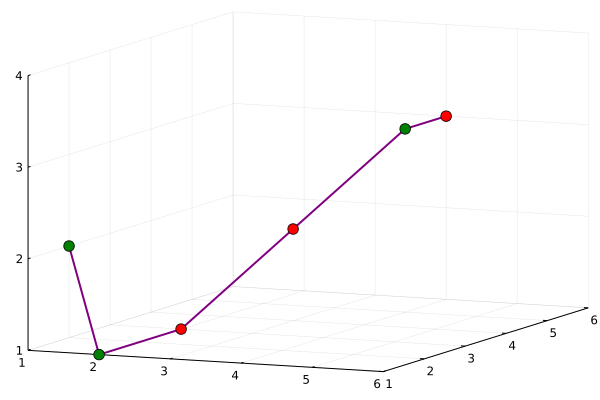

In [18]:
using Plots

edpx=[1,2,2,3,4,4]
edpy=[2,1,3,4,5,6]
edpz=[2,1,1,2,3,3]
xlims=(1,6)
ylims=(1,6)
zlims=(1,4)

hpl=[1,1,-1,-1,1,-1]
colours=[]

for j in 1:length(hpl)
    el=hpl[j]
    if el == 1
        push!(colours,"green")
    elseif el == -1
        push!(colours,"red")
    end
end

display(colours)
    

plot(edpx,edpy,edpz,lw=2,markershape=:circle,markercolor=colours,markersize=6,color="purple",label="")
xlims!(xlims)
ylims!(ylims)
zlims!(zlims)

In [ ]:
# First, declare basis vectors

v1=[1,0]
v2=[1//2,sqrt(3)//2]

tes1x=[v1[1]*j for j in 1:10]
tes1y=[v1[2]*j for j in 1:10]
tes2x=[v2[1]*j for j in 1:10]
tes2y=[v2[2]*j for j in 1:10]


scatter()

In [11]:
dc=Vector{Int8}[]
push!(dc,[1,2])

1-element Vector{Vector{Int8}}:
 [1, 2]